In [1]:
from main import RF
from mmdit import MMDiT_for_IN1K
import torch



rf = RF(
    MMDiT_for_IN1K(
        in_channels=4,
        out_channels=4,
        dim=2560,
        global_conddim=2560,
        n_layers=24,
        n_heads=8,
    ),
    True,
).cuda()

rf.load_state_dict(torch.load('/home/host/simo/ckpts/5b_2/model_57345/ema1.pt')) # checkpoint after getting high loss
rf.eval()

    

/home/host/py39cuda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2024-05-14 09:05:32,800] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH
 [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.3
 [WARNING]  using untested triton version (2.3.0), only 1.0.0 is known to be compatible


RF(
  (model): MMDiT_for_IN1K(
    (t_embedder): TimestepEmbedder(
      (mlp): Sequential(
        (0): Linear(in_features=256, out_features=2560, bias=True)
        (1): SiLU()
        (2): Linear(in_features=2560, out_features=2560, bias=True)
      )
    )
    (c_vec_embedder): Embedding(1024, 2560)
    (cond_seq_linear): MultiTokenEmbedding(
      (embedding1): Embedding(1024, 2560)
      (embedding2): Embedding(1024, 2560)
    )
    (init_x_linear): Linear(in_features=16, out_features=2560, bias=True)
    (layers): ModuleList(
      (0-22): 23 x MMDiTBlock(
        (normC1): Fp32LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (normC2): Fp32LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (mlpC): MLP(
          (c_fc1): Linear(in_features=2560, out_features=6912, bias=False)
          (c_fc2): Linear(in_features=2560, out_features=6912, bias=False)
          (c_proj): Linear(in_features=6912, out_features=2560, bias=False)
        )
        (modC): Seq

In [52]:

conds = [142, 145, 933, 849, 94, 333, 980, 22, 77]

L = len(conds)
#conds = [1, ] * 4
conds = torch.tensor(conds).cuda()
init_noise = torch.randn(L, 4, 32, 32).cuda()
#conds = torch.randint(0, 999, (L,)).cuda()
STEPSIZE = 50
images = rf.sample_with_xps(init_noise, conds, null_cond = torch.tensor([1000] * L).cuda(), sample_steps = STEPSIZE, cfg = 7.0)

In [3]:
from diffusers.image_processor import VaeImageProcessor
from diffusers.models import AutoencoderKL

vae = AutoencoderKL.from_pretrained("stabilityai/sdxl-vae").to("cuda:0")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [53]:
images_for_grid = [[] for _ in range(L)]

for i, labidx in enumerate(conds[:L]):
    for t in range(STEPSIZE):
        x = vae.decode(images[t][i : i + 1].cuda()/0.13025).sample
        img = VaeImageProcessor().postprocess(
            image=x.detach(), do_denormalize=[True, True]
        )[0]
        images_for_grid[i].append(img)

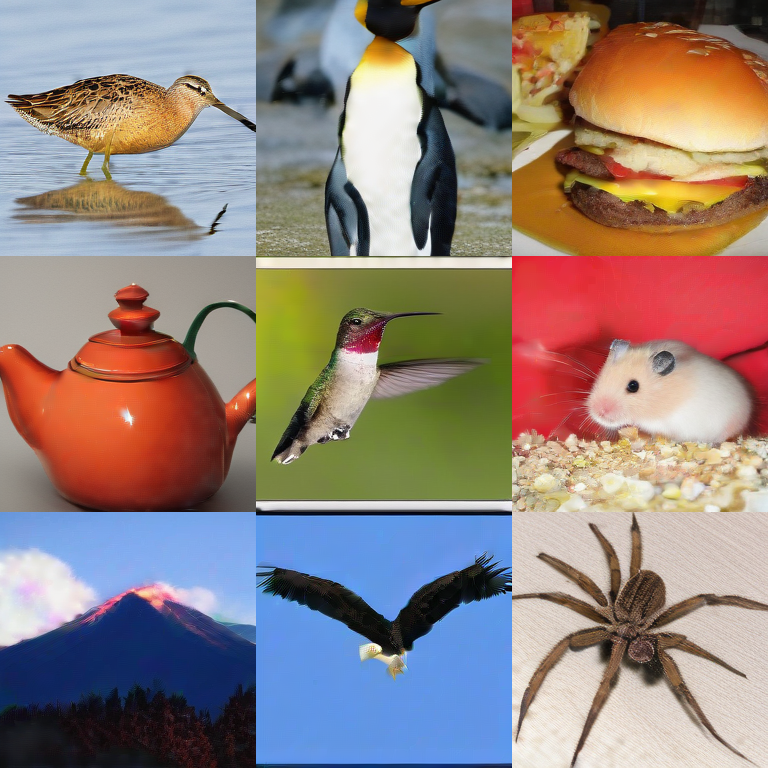

In [56]:
# plot 4 of them in grid
import PIL.Image as Image
grid_images = []
import math
sL = math.ceil(math.sqrt(L))
for t in range(STEPSIZE):
    
    grid = Image.new('RGB', (256*sL, 256*sL))
    for i in range(L):
        img = images_for_grid[i][t]
 
        grid.paste(img, (256 * (i % sL), 256 * (i // sL)))
    grid_images.append(grid)

# make it gif
# make last image lnger
grid_images += [grid_images[-1]] * 15
grid_images[-1]

In [ ]:
conds
142, 145, 933, 849, 

In [57]:
grid_images[0].save('out_IN5.4b.gif', save_all=True, append_images=grid_images[1:], duration=150, loop=0)
